In [78]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from utils import *
import os

sns.set(style='whitegrid') # Set seaborn style for better visuals

### DBSCAN Logic:

In [79]:
# Function to run DBSCAN and evaluate + visualize results, calling methods from utils.py
def run_dbscan(X, y_true, eps=0.5, min_samples=5, title=''):
    # Standardize features 
    X_scaled = StandardScaler().fit_transform(X)
    
    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples) 
    y_pred = dbscan.fit_predict(X_scaled)
    
    # Number of clusters and noise points
    n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0) # number of clusters excluding noise 'cluster'
    n_noise = list(y_pred).count(-1) 

    # Visualization
    if X_scaled.shape[1] == 2:
        visualize_clustering_2D(X_scaled, y_pred, y_true, title=title)
    elif X_scaled.shape[1] >= 3:
        visualize_clustering_3D(X_scaled, y_pred, y_true, title=title)
    else:
        print("Data has less than 2 dimensions; cannot visualise")

    print(f"Estimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise}")
    print("---------------------------------------------")
    
    # Evaluation Metrics
    evaluate_clustering(X_scaled, y_pred, y_true, n_clusters, title=title)
    
    return dbscan


### Hyperparameter Tuning (based on AMI)

In [80]:
# Gridsearch to return best params, then run dbscan on those results 
def tune_dbscan_params(X, y_true, eps_values, min_samples_values):
    # Standardize features
    X_scaled = StandardScaler().fit_transform(X)
    
    best_ami = -1
    best_params = {'eps': None, 'min_samples': None}

    for eps in eps_values:
        for min_samples in min_samples_values:
            # Run DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            y_pred = dbscan.fit_predict(X_scaled)

            # Number of clusters and noise points
            n_clusters = len(set(y_pred)) - (1 if -1 in y_pred else 0)
            # Skip if only one cluster or all noise
            if n_clusters <= 1:
                continue

            # Evaluate clustering silently
            ami, _, _ = evaluate_clustering(X_scaled, y_pred, y_true, n_clusters, verbose=False)

            # Keep track of best parameters
            if ami > best_ami:
                best_ami = ami
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

    return best_params

In [81]:
# Datasets and initial parameter guesses (parameters can be empty now)
datasets_dir = 'datasets'
datasets = [
    ('isotropic_blobs.csv', {}, 'Isotropic Gaussian Blobs'),
    ('anisotropic_blobs.csv', {}, 'Anisotropic Gaussian Blobs'),
    ('moons_circles.csv', {}, 'Moons and Circles'),
    ('overlapping_clusters.csv', {}, 'Overlapping Clusters'),
    ('high_dimensional_data.csv', {}, 'High-Dimensional Data with Noise'),
    ('anisotropic_high_dimensional_data3.csv', {}, 'Anisotropic High-Dimensional Data with Noise')] # additional dataset for Density based algorithms 

### Main Driver Code:


Processing Isotropic Gaussian Blobs...
Best parameters for Isotropic Gaussian Blobs: eps=0.30000000000000004, min_samples=14


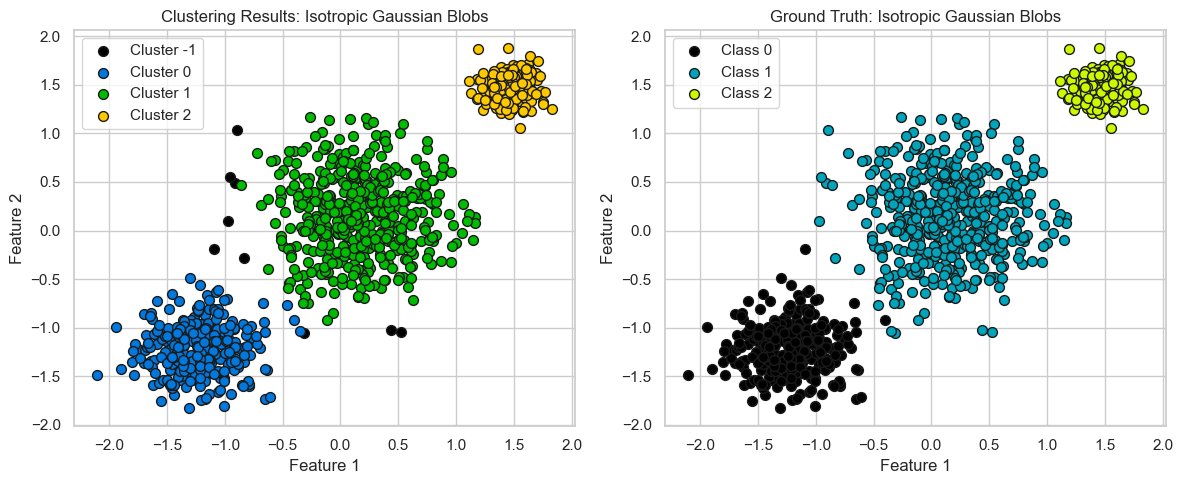

Estimated number of clusters: 3
Estimated number of noise points: 9
---------------------------------------------
Isotropic Gaussian Blobs
Adjusted Mutual Information: 0.9638
V-measure: 0.9639

Processing Anisotropic Gaussian Blobs...
Best parameters for Anisotropic Gaussian Blobs: eps=0.30000000000000004, min_samples=16


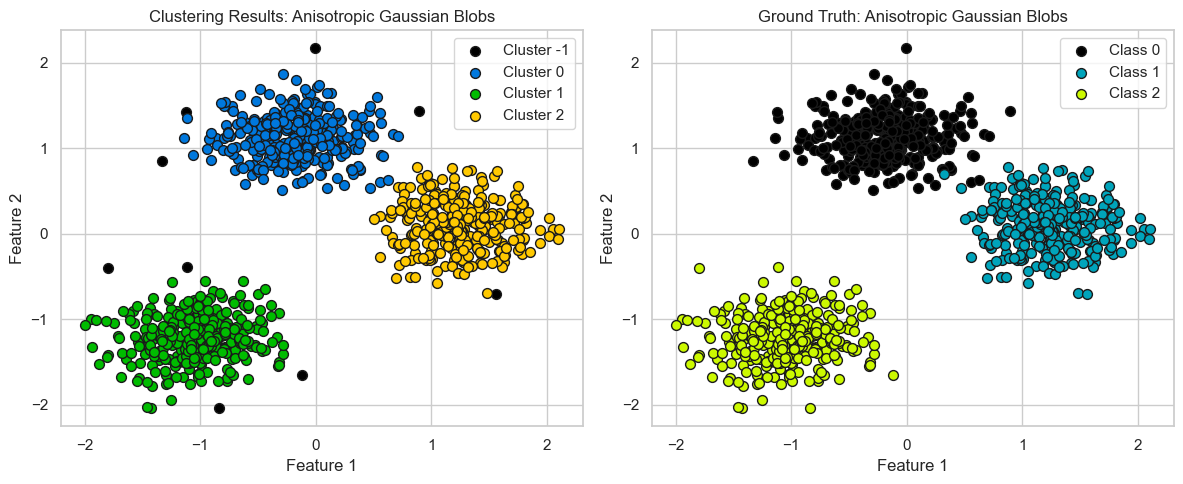

Estimated number of clusters: 3
Estimated number of noise points: 9
---------------------------------------------
Anisotropic Gaussian Blobs
Adjusted Mutual Information: 0.9627
V-measure: 0.9628

Processing Moons and Circles...
Best parameters for Moons and Circles: eps=0.15000000000000002, min_samples=2


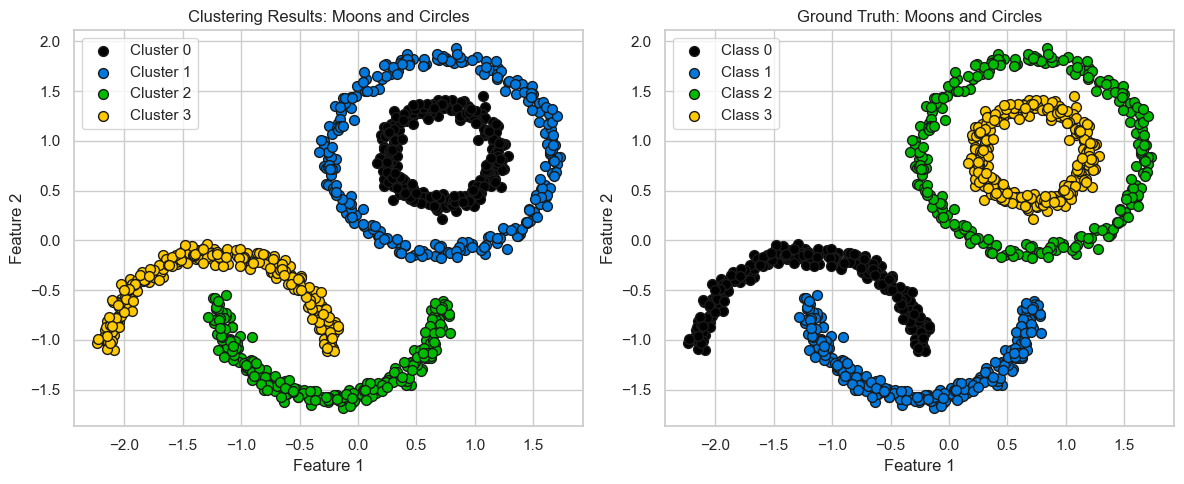

Estimated number of clusters: 4
Estimated number of noise points: 0
---------------------------------------------
Moons and Circles
Adjusted Mutual Information: 1.0000
V-measure: 1.0000

Processing Overlapping Clusters...
Best parameters for Overlapping Clusters: eps=0.2, min_samples=18


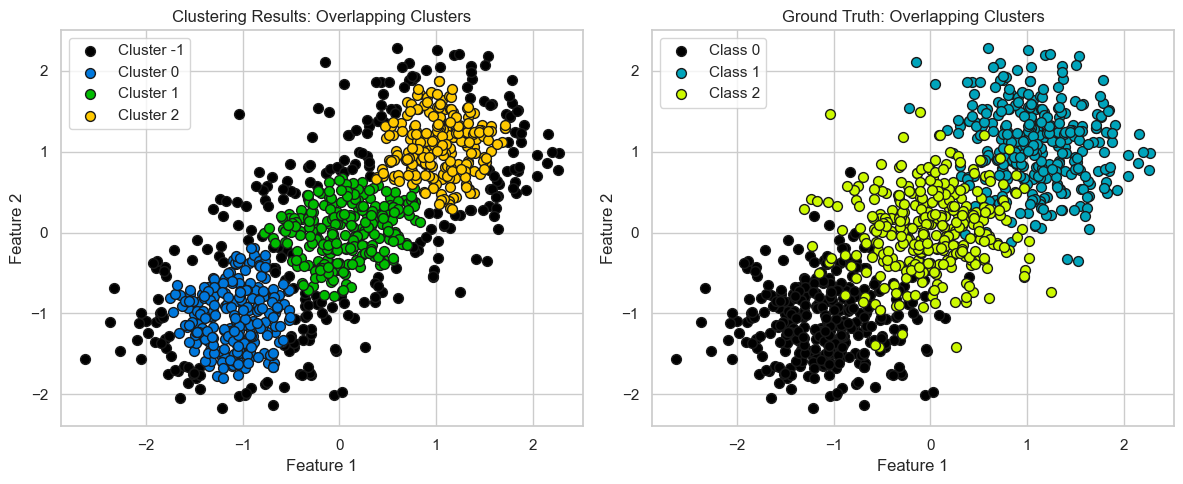

Estimated number of clusters: 3
Estimated number of noise points: 272
---------------------------------------------
Overlapping Clusters
Adjusted Mutual Information: 0.4827
V-measure: 0.4839

Processing High-Dimensional Data with Noise...
No suitable parameters found for High-Dimensional Data with Noise. Using default parameters.
Data has been reduced to 3D using PCA for visualization.


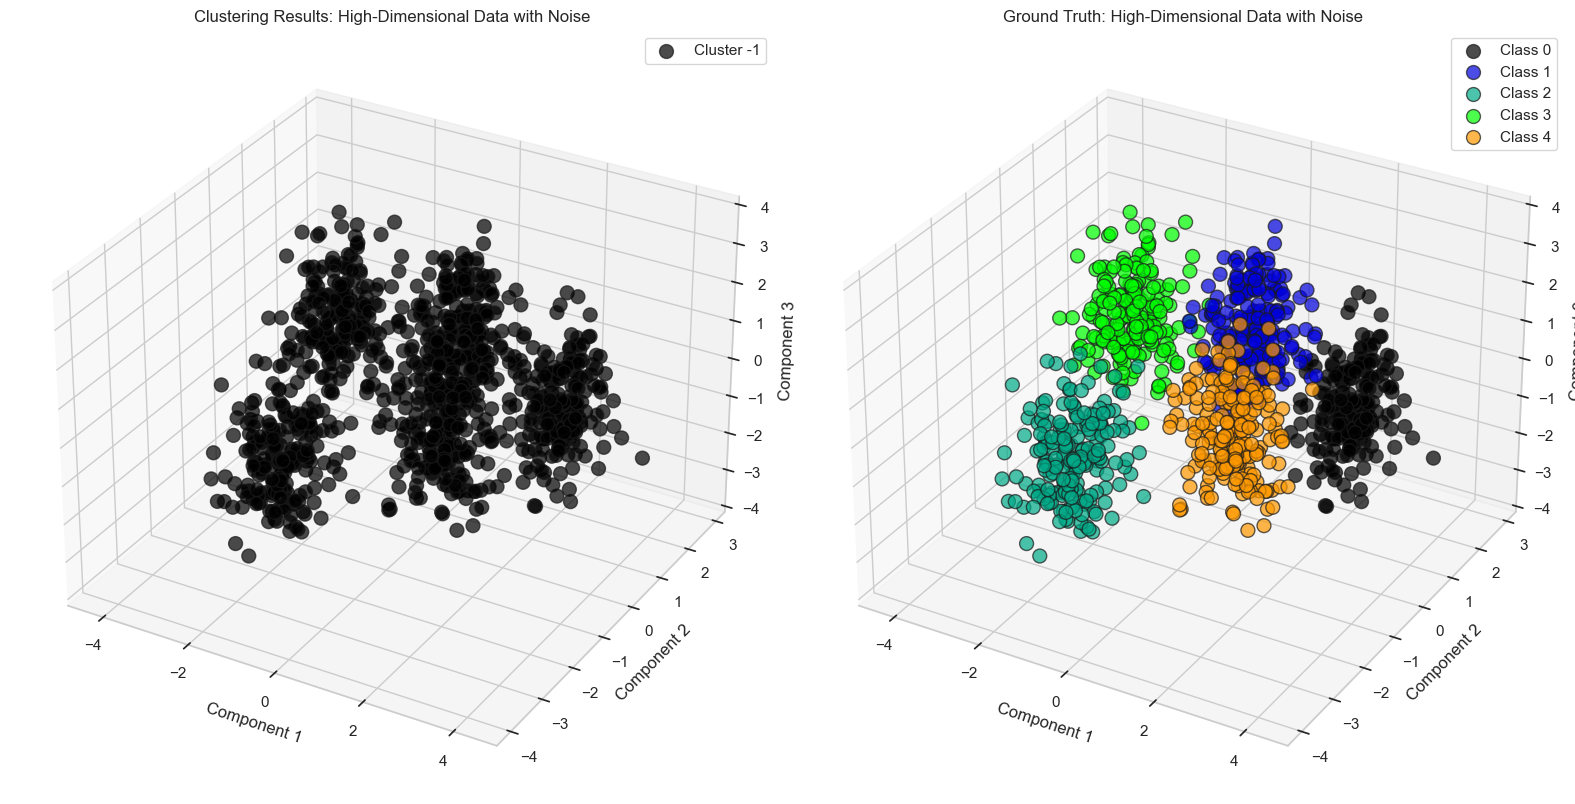

Estimated number of clusters: 0
Estimated number of noise points: 1000
---------------------------------------------
High-Dimensional Data with Noise
Adjusted Mutual Information: 0.0000
V-measure: 0.0000
Silhouette Score: Cannot be calculated with less than 2 clusters.

Processing Anisotropic High-Dimensional Data with Noise...
No suitable parameters found for Anisotropic High-Dimensional Data with Noise. Using default parameters.
Data has been reduced to 3D using PCA for visualization.


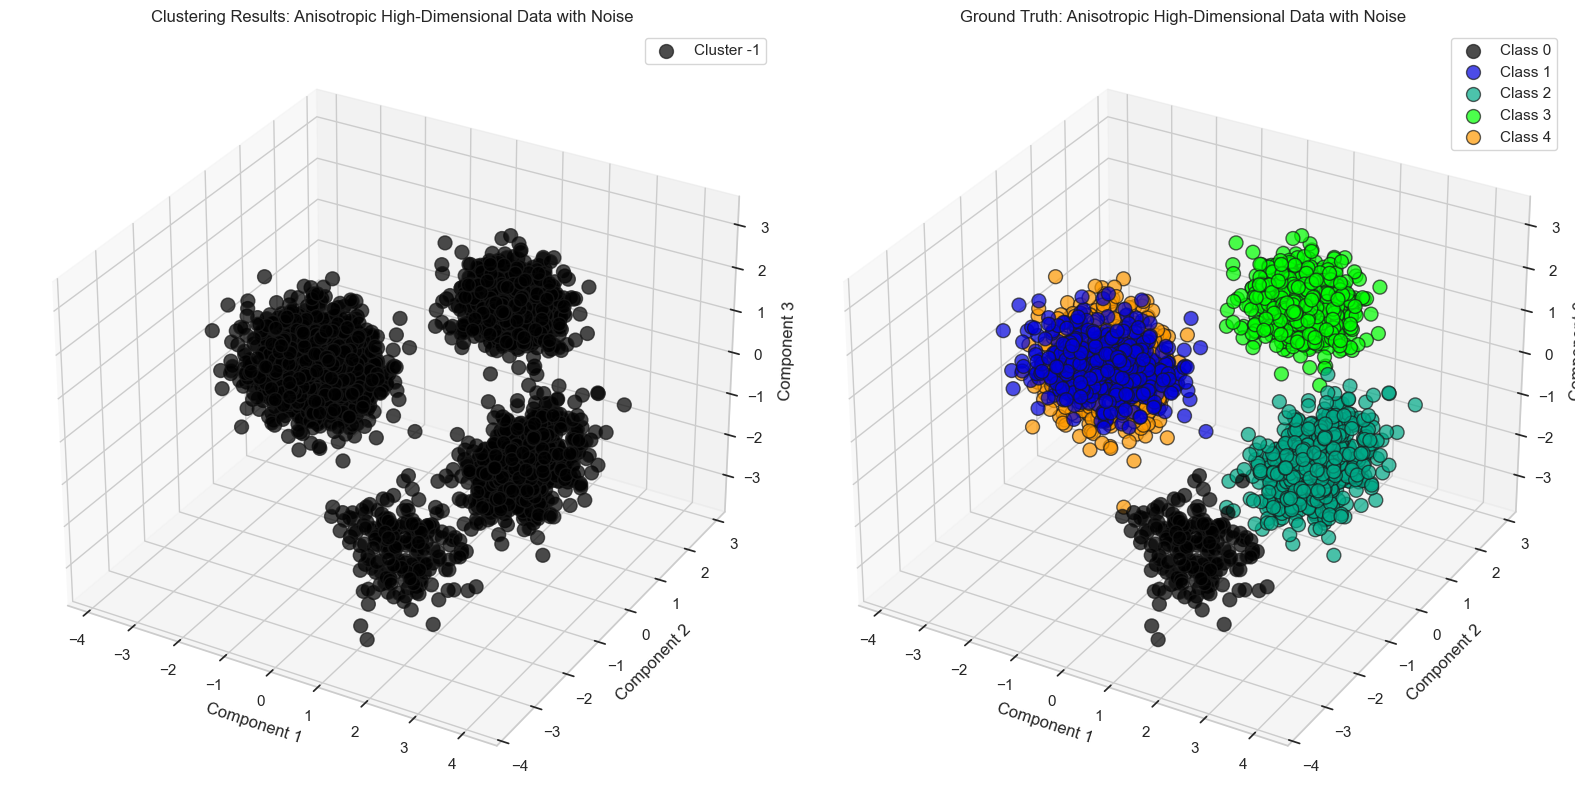

Estimated number of clusters: 0
Estimated number of noise points: 3400
---------------------------------------------
Anisotropic High-Dimensional Data with Noise
Adjusted Mutual Information: 0.0000
V-measure: 0.0000
Silhouette Score: Cannot be calculated with less than 2 clusters.


In [82]:
# Run DBSCAN with hyperparameter tuning for each dataset
for filename, params, title in datasets:
    print(f"\nProcessing {title}...")
    filepath = os.path.join(datasets_dir, filename)
    X, y_true = load_dataset(filepath)

    # Define parameter ranges (educated guesses for now.)
    if title == 'Isotropic Gaussian Blobs':
        eps_values = np.linspace(0.1, 1.0, 10)
        min_samples_values = range(2, 20, 2)
    elif title == 'Anisotropic Gaussian Blobs':
        eps_values = np.linspace(0.1, 1.0, 10)
        min_samples_values = range(2, 20, 2)
    elif title == 'Moons and Circles':
        eps_values = np.linspace(0.05, 0.5, 10)
        min_samples_values = range(2, 20, 2)
    elif title == 'Overlapping Clusters':
        eps_values = np.linspace(0.1, 1.0, 10)
        min_samples_values = range(2, 20, 2)
    elif title == 'High-Dimensional Data with Noise':
        eps_values = np.linspace(0.5, 5.0, 10)
        min_samples_values = range(2, 30, 4)
    elif title == 'Anisotropic High-Dimensional Data with Noise': # Additional 
        eps_values = np.linspace(0.5, 5.0, 10)
        min_samples_values = range(2, 30, 4)
    else:
        eps_values = np.linspace(0.1, 1.0, 10)
        min_samples_values = range(2, 20, 2)

    # Tune hyperparameters
    best_params = tune_dbscan_params(X, y_true, eps_values, min_samples_values)

    if best_params['eps'] is not None:
        # Update params with best parameters
        params['eps'] = best_params['eps']
        params['min_samples'] = best_params['min_samples']
        print(f"Best parameters for {title}: eps={params['eps']}, min_samples={params['min_samples']}")
    else:
        # Use default parameters if no best parameters found
        params['eps'] = eps_values[0]
        params['min_samples'] = min_samples_values[0]
        print(f"No suitable parameters found for {title}. Using default parameters.")

    # Run DBSCAN with best parameters and visualize results as before
    dbscan = run_dbscan(X, y_true, eps=params['eps'], min_samples=params['min_samples'], title=title)

### Apply UMAP reduction for DBSCAN for high dimensional data

In [83]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [84]:
# Import UMAP
import umap.umap_ as umap

# Load high-dimensional dataset
dataset_name = 'High-Dimensional Data with Noise'
filename = 'high_dimensional_data.csv'
filepath = os.path.join(datasets_dir, filename)
X_high_dim, y_true_high_dim = load_dataset(filepath)

# Apply UMAP to reduce dimensionality to 3D
n_components = 12
umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = umap_reducer.fit_transform(X_high_dim)

print(f"Original shape: {X_high_dim.shape}")
print(f"Reduced shape: {X_reduced.shape}")


c:\Users\sharm\anaconda3\envs\virtual\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Original shape: (1000, 60)
Reduced shape: (1000, 12)


Best parameters for High-Dimensional Data with Noise after UMAP: eps=1.0, min_samples=2
Data has been reduced to 3D using PCA for visualization.


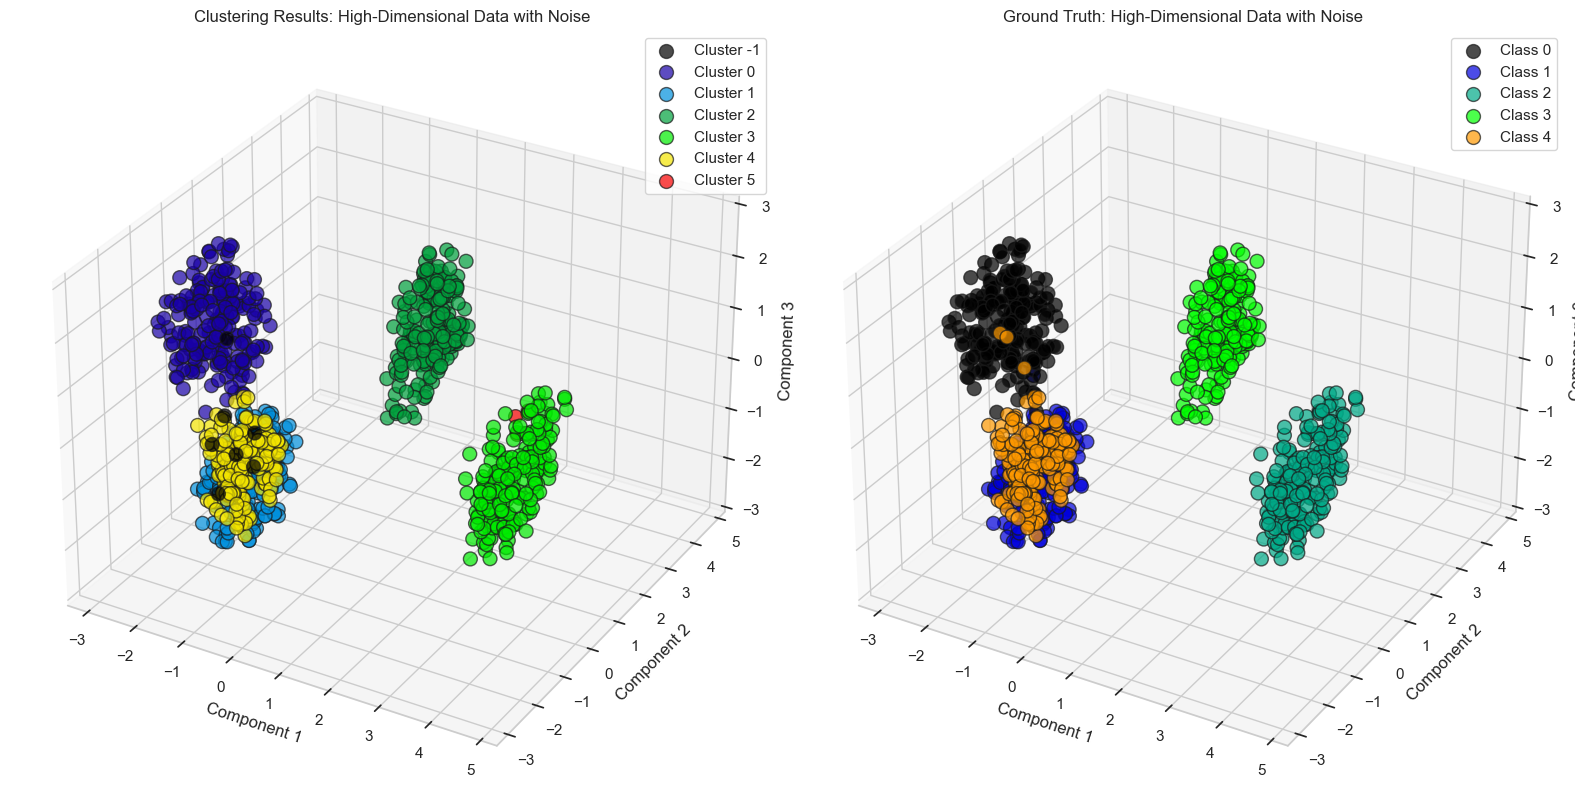

Estimated number of clusters: 6
Estimated number of noise points: 8
---------------------------------------------
High-Dimensional Data with Noise
Adjusted Mutual Information: 0.9583
V-measure: 0.9586


In [85]:
# Define parameter ranges for tuning
eps_values = np.linspace(0.5, 5.0, 10)
min_samples_values = range(2, 30, 4)

# Tune hyperparameters on reduced data
best_params = tune_dbscan_params(X_reduced, y_true_high_dim, eps_values, min_samples_values)

if best_params['eps'] is not None:
    # Update params with best parameters
    params = {}
    params['eps'] = best_params['eps']
    params['min_samples'] = best_params['min_samples']
    print(f"Best parameters for {dataset_name} after UMAP: eps={params['eps']}, min_samples={params['min_samples']}")
else:
    # Use default parameters if no best parameters found
    params = {'eps': eps_values[0], 'min_samples': min_samples_values[0]}
    print(f"No suitable parameters found for {dataset_name}. Using default parameters.")

# Run DBSCAN with best parameters and visualize results
dbscan = run_dbscan(X_reduced, y_true_high_dim, eps=params['eps'], min_samples=params['min_samples'], title=dataset_name)


### Running the same approach on Anisotropic High Dimensional Data

In [86]:
# Import UMAP
import umap.umap_ as umap

# Load high-dimensional dataset
dataset_name = 'Anisotropic High-Dimensional Data'
filename = 'anisotropic_high_dimensional_data3.csv'
filepath = os.path.join(datasets_dir, filename)
X_high_dim, y_true_high_dim = load_dataset(filepath)

# Apply UMAP to reduce dimensionality to 3D
n_components = 12
umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
X_reduced = umap_reducer.fit_transform(X_high_dim)

print(f"Original shape: {X_high_dim.shape}")
print(f"Reduced shape: {X_reduced.shape}")

c:\Users\sharm\anaconda3\envs\virtual\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Original shape: (3400, 60)
Reduced shape: (3400, 12)


Best parameters for Anisotropic High-Dimensional Data after UMAP: eps=1.0, min_samples=18
Data has been reduced to 3D using PCA for visualization.


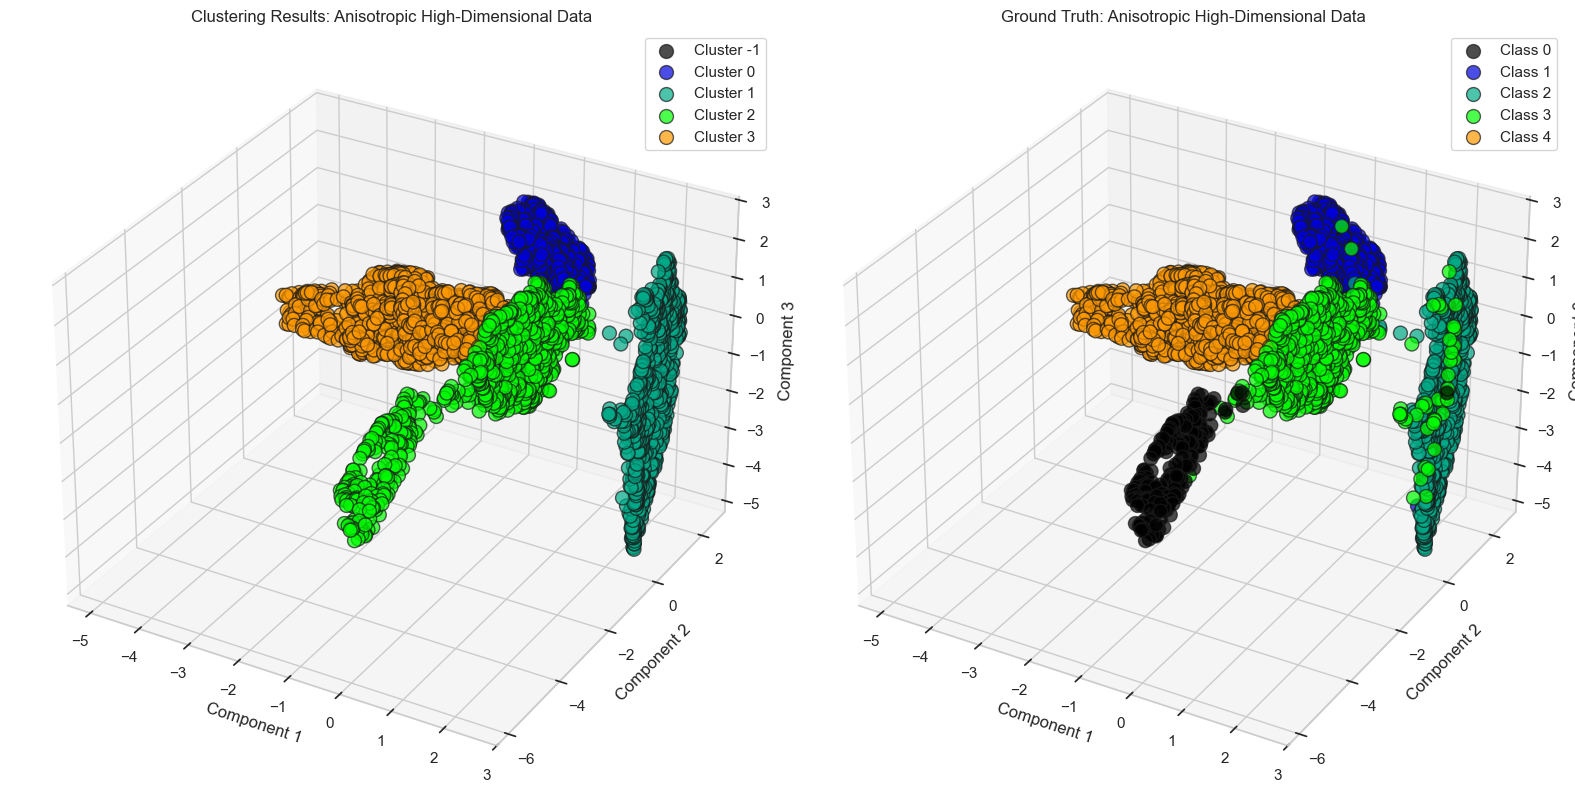

Estimated number of clusters: 4
Estimated number of noise points: 24
---------------------------------------------
Anisotropic High-Dimensional Data
Adjusted Mutual Information: 0.8820
V-measure: 0.8822


In [87]:
# Define parameter ranges for tuning
eps_values = np.linspace(0.5, 5.0, 10)
min_samples_values = range(2, 30, 4)

# Tune hyperparameters on reduced data
best_params = tune_dbscan_params(X_reduced, y_true_high_dim, eps_values, min_samples_values)

# Check output
if best_params['eps'] is not None:
    # Update params with best parameters
    params = {}
    params['eps'] = best_params['eps']
    params['min_samples'] = best_params['min_samples']
    print(f"Best parameters for {dataset_name} after UMAP: eps={params['eps']}, min_samples={params['min_samples']}")
else:
    # Use default parameters if no best parameters found
    params = {'eps': eps_values[0], 'min_samples': min_samples_values[0]}
    print(f"No suitable parameters found for {dataset_name}. Using default parameters.")

# Run DBSCAN with best parameters and visualize results
dbscan = run_dbscan(X_reduced, y_true_high_dim, eps=params['eps'], min_samples=params['min_samples'], title=dataset_name)
